In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest

In [2]:
# データセットの読み込み
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')

# train_dataとtest_dataの連結
test_data['Survived'] = np.nan
df = pd.concat([train_data, test_data], ignore_index=True, sort=False)

# dfの情報
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [3]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1:])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/542509138.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')


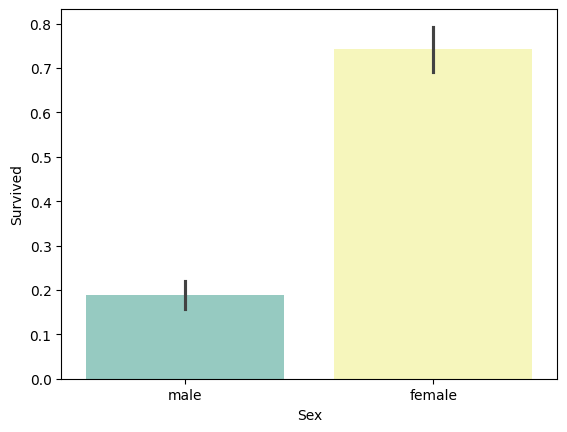

In [4]:
# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Set3')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)


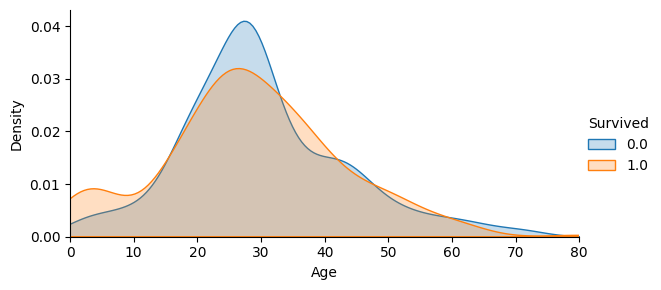

In [5]:
# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()


/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/374236940.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/374236940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Title', y='Survived', data=df, palette='

<Axes: xlabel='Title', ylabel='Survived'>

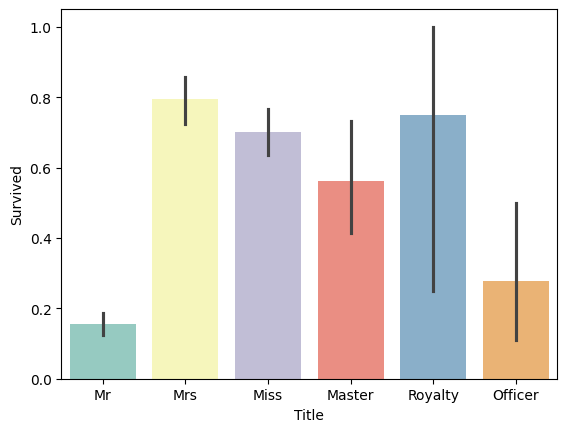

In [6]:
# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')


In [7]:
# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 


In [8]:
# 家族で16才以下または女性の生存率
Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

Survived
1.000000    113
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: count, dtype: int64


In [9]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

Survived
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: count, dtype: int64


In [10]:
# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']


Dead_list =  {'Lefebre', 'Arnold-Franchi', 'Ford', 'Skoog', 'Strom', 'Caram', 'Danbom', 'Attalah', 'Ilmakangas', 'Lobb', 'Canavan', 'Elias', 'Van Impe', 'Sage', 'Rice', 'Palsson', 'Jussila', 'Barbara', 'Bourke', 'Vander Planke', 'Turpin', 'Johnston', 'Robins', 'Goodwin', 'Zabour', 'Lahtinen', 'Olsson', 'Panula', 'Boulos', 'Cacic', 'Rosblom', 'Oreskovic'}
Survived_list =  {'Moubarek', 'Cardeza', 'McCoy', 'Beane', 'Greenfield', 'Harder', 'Dick', 'Frolicher-Stehli', 'Goldenberg', 'Bradley', 'Jussila', 'Bishop', 'Daly', 'Nakid', 'Kimball', 'Taylor', 'Frauenthal', 'Duff Gordon', 'Chambers', 'Beckwith', 'Jonsson'}


In [11]:
# ----------- Fare -------------
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)


In [12]:
# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0


/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/3130724292.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')


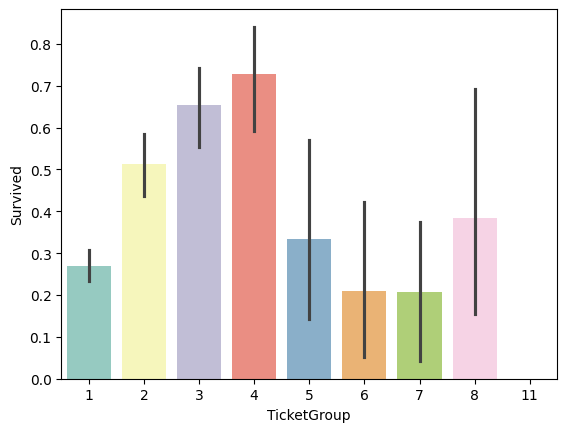

In [13]:
# ----------- Ticket ----------------
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()


/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/3694857350.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')


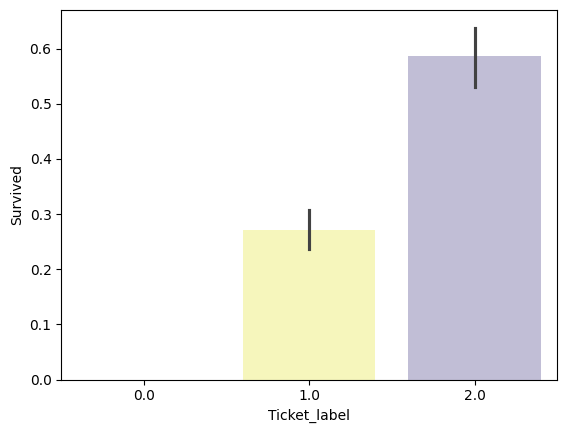

In [14]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()


/var/folders/nz/pdh3wbl139nfbnd6j9xbwx300000gn/T/ipykernel_43084/3627864716.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')


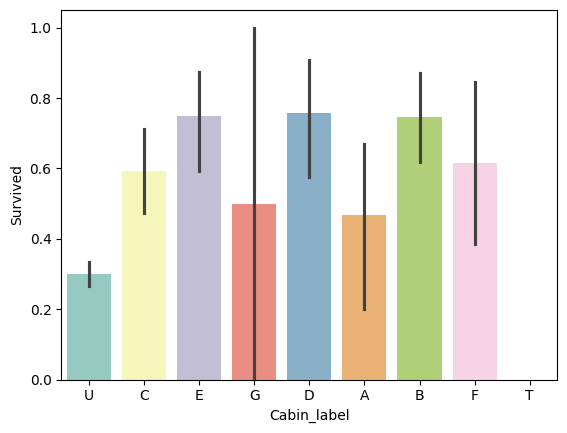

In [15]:
# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()


In [16]:
# ---------- Embarked ---------------
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 


In [17]:
df.to_csv("./titanic/processed_data.csv", index=False)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   1309 non-null   int64  
 1   Survived      891 non-null    float64
 2   Pclass        1309 non-null   int64  
 3   Name          1309 non-null   object 
 4   Sex           1309 non-null   object 
 5   Age           1309 non-null   float64
 6   SibSp         1309 non-null   int64  
 7   Parch         1309 non-null   int64  
 8   Ticket        1309 non-null   object 
 9   Fare          1309 non-null   float64
 10  Cabin         1309 non-null   object 
 11  Embarked      1309 non-null   object 
 12  Title         1309 non-null   object 
 13  Surname       1309 non-null   object 
 14  FamilyGroup   1309 non-null   int64  
 15  Family        1309 non-null   int64  
 16  Family_label  1309 non-null   float64
 17  TicketGroup   1309 non-null   int64  
 18  Ticket_label  1309 non-null 

In [18]:
# ------------- 前処理 ---------------
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values


In [19]:
# 特徴量選択のためにSelectKBestを使用
selector = SelectKBest(k=20)
selector.fit(X, y)

# 選択された特徴量を取得
selected_features = selector.get_support(indices=True)
selected_feature_names = df.columns[1:][selected_features]

print("Selected features:", selected_feature_names)

Selected features: Index(['Pclass', 'Age', 'Fare', 'Family_label', 'Ticket_label', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_S', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Royalty', 'Cabin_label_B',
       'Cabin_label_C', 'Cabin_label_D', 'Cabin_label_E', 'Cabin_label_F',
       'Cabin_label_U'],
      dtype='object')


In [20]:
X_selected = selector.transform(X)
y_class = y.astype(int)
test_x_selected = selector.transform(test_x)

In [21]:
# from sklearn.ensemble import RandomForestClassifier

# # ランダムフォレストモデルのインスタンスを作成
# clf = RandomForestClassifier(n_estimators=100, random_state=42)

# # モデルを学習
# clf.fit(X_selected, y_class)
# # モデルの精度を評価
# accuracy = clf.score(X_selected, y_class)
# print(f"Accuracy: {accuracy}")

# # テストデータに対して予測
# predictions = clf.predict(test_x_selected)

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# データ型の変換
X_selected = np.array(X_selected, dtype=np.float32)
y_class = np.array(y_class, dtype=np.float32)
test_x_selected = np.array(test_x_selected, dtype=np.float32)
# モデルの構築
model = Sequential()
model.add(Dense(64, input_dim=X_selected.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# モデルのコンパイル
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# モデルの学習
model.fit(X_selected, y_class, epochs=500, batch_size=32, validation_split=0.2)

# テストデータに対して予測
nn_predictions = model.predict(test_x_selected)
nn_predictions = (nn_predictions > 0.5).astype(int).flatten()

# モデルの精度を評価
loss, accuracy = model.evaluate(X_selected, y_class)
print(f"Neural Network Accuracy: {accuracy}")

Epoch 1/500


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5168 - loss: 3.7920 - val_accuracy: 0.6425 - val_loss: 0.6486
Epoch 2/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5056 - loss: 2.6992 - val_accuracy: 0.7039 - val_loss: 0.7333
Epoch 3/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5765 - loss: 2.2031 - val_accuracy: 0.6927 - val_loss: 0.6212
Epoch 4/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5570 - loss: 2.0256 - val_accuracy: 0.7039 - val_loss: 0.5700
Epoch 5/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6062 - loss: 1.6549 - val_accuracy: 0.6983 - val_loss: 0.5566
Epoch 6/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6078 - loss: 1.5252 - val_accuracy: 0.7318 - val_loss: 0.5353
Epoch 7/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 1.5095 - val_accuracy: 0.7151 - val_loss: 0.5408
Epoch 8/500
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5692 - loss: 1.3256 - val_accuracy: 0.7263 - val_loss: 0.5

In [23]:
# 予測結果をデータフレームに変換
submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": nn_predictions
})

# CSVファイルとして保存
submission.to_csv("./titanic/submission.csv", index=False)